### IMPORT PACKAGES

import pandas as pd
import json
import requests 
import networkx as nx 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pyspark import SparkContext
import numpy as np
from itertools import combinations
from pandas import Series

import ast
from tqdm import tqdm
tqdm.pandas()

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',100)
pd.set_option('display.max_colwidth', 100)


### IMPORT DATA and FILTER DATA NEEDED TO COMPILE WALLET ADDRESESS

In [5]:
df = pd.read_csv('Data_API.csv')

/sw/arcts/centos7/python3.8-anaconda/2021.05/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,1,2,4,6,8,9,10,14,15,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
df.head()

,Smart_contract,ID_token,Transaction_hash,Seller_address,Seller_username,Buyer_address,Buyer_username,Image_url_1,Image_url_2,Image_url_3,Image_url_4,Price_Crypto,Crypto,Price_USD,Name,Description,Collection,Market,Datetime_updated,Datetime_updated_seconds,Permanent_link,Unique_id_collection,Collection_cleaned,Category
0,NaN,87094722.0,0xed9ff1c311a611e5c457ce0a49bbbb7ed55efca988421aee27a01a8f8f6810f2,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,NaN,0xe0fb7622091e3d9ef9b438471b10b9ea88c7cf6b,NaN,https://card.godsunchained.com/?id=33&q=4,NaN,NaN,NaN,0.0002,ETH,0.030318,NaN,NaN,Godsunchained,Godsunchained,2019-11-30 00:00:00,2019-11-30 23:59:33,NaN,"('Godsunchained', '87094722.0')",Godsunchained,Games
1,NaN,73044643.0,0xbc8412594ffa7382e8306215ece5b4e041fc641b18133221925a4ac6ecf15432,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,NaN,0x2c00d05ff7ffe93d77145dfe12aa56e622ae6f40,NaN,https://card.godsunchained.com/?id=79&q=4,NaN,NaN,NaN,0.0013,ETH,0.197067,NaN,NaN,Godsunchained,Godsunchained,2019-11-30 00:00:00,2019-11-30 23:59:33,NaN,"('Godsunchained', '73044643.0')",Godsunchained,Games
2,NaN,17107482.0,0x92672baf5e9e23de230dee8e57ddf443ab6d5a3363414ec48e50433e336004b0,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,NaN,0xe0fb7622091e3d9ef9b438471b10b9ea88c7cf6b,NaN,https://card.godsunchained.com/?id=33&q=4,NaN,NaN,NaN,0.0002,ETH,0.030318,NaN,NaN,Godsunchained,Godsunchained,2019-11-30 00:00:00,2019-11-30 23:59:33,NaN,"('Godsunchained', '17107482.0')",Godsunchained,Games
3,NaN,82230857.0,0x3d157249e3083622c2d756f07a05caa3a76687288b32c81ab6c1acc397df661f,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,NaN,0x2c00d05ff7ffe93d77145dfe12aa56e622ae6f40,NaN,https://card.godsunchained.com/?id=227&q=4,NaN,NaN,NaN,0.0022,ETH,0.333498,NaN,NaN,Godsunchained,Godsunchained,2019-11-30 00:00:00,2019-11-30 23:59:33,NaN,"('Godsunchained', '82230857.0')",Godsunchained,Games
4,NaN,40925443.0,0xa892b3569dc8e6b3c7db93aade62372637ebbc61fb635c7103433f86fcdd6f98,0x76481caa104b5f6bccb540dae4cefaf1c398ebea,NaN,0x2c00d05ff7ffe93d77145dfe12aa56e622ae6f40,NaN,https://card.godsunchained.com/?id=62&q=4,NaN,NaN,NaN,0.0012,ETH,0.181908,NaN,NaN,Godsunchained,Godsunchained,2019-11-30 00:00:00,2019-11-30 23:58:44,NaN,"('Godsunchained', '40925443.0')",Godsunchained,Games


In [7]:
df = df[df.Market == 'OpenSea']
addresses = df['Buyer_address'].unique()
len(addresses)

179560

In [8]:
df_addy = pd.DataFrame(addresses, columns = ['wallet_adresses'])
df_addy

,wallet_adresses
0,0x442dccee68425828c106a3662014b4f131e3bd9b
1,0xf165d353abddb7cb00052d610254249fcc12a8c7
2,0x24a6f141b18f27f65a1ba8b49e2d975d18e1a259
3,0x5b897d015dbb2661e1fd4a0df68322dfaec6ea14
4,0xb58092199e8b47bd9e27533d9504282eb802c446
...,...
179555,0xea9f939bf101f070875900831bd0340c0b8064a3
179556,0x5c2a00d4051455f05829d818dac18e438124e79c
179557,0x8ee1c45bb1bef0021c6a3c6d45e8c043b62dc05e
179558,0xf636222ae1103492af8675bb9e2e85f023001f65


### Functions to Call each Wallet and then get NFT

In [9]:
def get_response(wallet_address):
    try: 
        asset_owner_wallet_url = str(wallet_address)
        url = "https://api.opensea.io/api/v1/collections?asset_owner={}&offset=0&limit=300".format(asset_owner_wallet_url)
        headers = {"Accept": "application/json"}
        response = requests.request("GET", url, headers=headers)
        #return response.apply(get_nft_names)
        j = json.loads(response.text)
    except:
        return[]  
    
    try: 
        return j
    except:
        print('skipped_return')

In [10]:
def get_nft_names(json_text):
    if json_text == []:
        return None 
    else:
        names = []
        for nft in json_text:         
            if nft['primary_asset_contracts'] == []:
                return None
            if nft['primary_asset_contracts'][0] == []:
                return 'empty_name'
            else:
                nft_name = nft['primary_asset_contracts'][0]['name']
            names.append(nft_name)
        return names

## TEST DATA 

#### Sample data used to get nft data and transfer into adjacency matrix 

In [12]:
test_df = df_addy.sample(100)
test_df

,wallet_adresses
90879,0x1876a18fe171356e2fb27dec743e4b51d95adf38
72873,0x431b5ddb0ace97ebc3d936403ea25831bad832b6
144925,0x8e4cd33ad8830d7640d2c14169df003d7b560d2b
174270,0x98a3b0de38ba11792806efb862f56e0fccf385b2
9204,0x9074485a2b1d4060b2ca3d808fd82e4629202ee3
99166,0x0839e551380dff5b8022240de8168118de9f0126
48933,0x229d72204bb3dc55c02c0a37b7122b447a72ad34
148853,0x2dc80972d19ff5ae08911bfd9e211d4573156a5b
7190,0xcede8920bc434bf1bfb445d27d19acdfe6718684
152555,0xb9aa7ba3dafda5fe30199f8263ec4e41e8207da9


In [13]:
test_df['response'] = test_df['wallet_adresses'].progress_apply(get_response)
#test_df.iloc[0].response[0]['primary_asset_contracts'][0]['name']
test_df

100%|██████████| 100/100 [00:32<00:00,  3.06it/s]


,wallet_adresses,response
90879,0x1876a18fe171356e2fb27dec743e4b51d95adf38,"[{'primary_asset_contracts': [{'address': '0x06012c8cf97bead5deae237070f9587f8e7a266d', 'asset_c..."
72873,0x431b5ddb0ace97ebc3d936403ea25831bad832b6,"[{'primary_asset_contracts': [{'address': '0xc3cd69649394bf1a18a7a0c7f90e4d0e4f1a9758', 'asset_c..."
144925,0x8e4cd33ad8830d7640d2c14169df003d7b560d2b,"[{'primary_asset_contracts': [{'address': '0x138ff21a21dfc06fbfccf15f2d9fd290a660e152', 'asset_c..."
174270,0x98a3b0de38ba11792806efb862f56e0fccf385b2,"[{'primary_asset_contracts': [], 'traits': {}, 'stats': {'one_day_volume': 0.0, 'one_day_change'..."
9204,0x9074485a2b1d4060b2ca3d808fd82e4629202ee3,"[{'primary_asset_contracts': [{'address': '0xc20cf2cda05d2355e218cb59f119e3948da65dfa', 'asset_c..."
99166,0x0839e551380dff5b8022240de8168118de9f0126,[]
48933,0x229d72204bb3dc55c02c0a37b7122b447a72ad34,"[{'primary_asset_contracts': [{'address': '0x06012c8cf97bead5deae237070f9587f8e7a266d', 'asset_c..."
148853,0x2dc80972d19ff5ae08911bfd9e211d4573156a5b,"[{'primary_asset_contracts': [{'address': '0x3b5932c43f345d422a4dbf6e7ae486cafb85f1d5', 'asset_c..."
7190,0xcede8920bc434bf1bfb445d27d19acdfe6718684,"[{'primary_asset_contracts': [{'address': '0x06012c8cf97bead5deae237070f9587f8e7a266d', 'asset_c..."
152555,0xb9aa7ba3dafda5fe30199f8263ec4e41e8207da9,[]


In [14]:
test_df['NFTS']= test_df['response'].progress_apply(get_nft_names)

100%|██████████| 100/100 [00:00<00:00, 46386.91it/s]


In [21]:
test_df.sample(7)

,wallet_adresses,response,NFTS
141308,0x26dd71418840d2d8505251d2c6445d9a5834d3bc,"[{'primary_asset_contracts': [{'address': '0x9abb7bddc43fa67c76a62d8c016513827f59be1b', 'asset_c...","[POW NFT, Rarible]"
91756,0xb62dc5706a658a5cc90c6bc1ce8fda59da311294,"[{'primary_asset_contracts': [{'address': '0x84f4226af1eb4b5e76c5dd203eef7f1f3452fb9d', 'asset_c...","[Metaverse Marauders, cometh spaceships, Rarible]"
58927,0xf65364f73687045970135889bf945f3589c9da93,"[{'primary_asset_contracts': [], 'traits': {}, 'stats': {'one_day_volume': 0.0, 'one_day_change'...",None
7190,0xcede8920bc434bf1bfb445d27d19acdfe6718684,"[{'primary_asset_contracts': [{'address': '0x06012c8cf97bead5deae237070f9587f8e7a266d', 'asset_c...",[CryptoKitties]
90879,0x1876a18fe171356e2fb27dec743e4b51d95adf38,"[{'primary_asset_contracts': [{'address': '0x06012c8cf97bead5deae237070f9587f8e7a266d', 'asset_c...",[CryptoKitties]
122809,0xc13acdb91e098be5c84b98fac1e58971f5be1212,"[{'primary_asset_contracts': [{'address': '0x6bf1181998221399ca08c1c9d13a7ca4e6a5fe9b', 'asset_c...",None
65048,0x1c587bf2e5d0419ad74bf9e6a6f44463e5bddedf,[],None


In [22]:
test_df = test_df.dropna()

In [23]:
test_df = test_df.drop('response', axis=1)

In [24]:
test_df['num'] = test_df['NFTS'].apply(len)

In [25]:
len(test_df)

64

In [27]:
multi_nft = test_df[test_df['num']>1]
multi_nft.sample(10)

,wallet_adresses,NFTS,num
12516,0x3294f3c6425e0277fdb4ff83c176da09f604ebbd,"[EtheremonMonster, CryptoKitties]",2
23470,0xb351172e43fea81e085a5046640250f76e367666,"[CryptoBots, CryptoKitties]",2
94384,0x9096a1db0cbd112ceaa648542d3a361e925b2554,"[FroyoKittens, ARBO Artifacts, ARBO Heroes, The Tiger Archives, Axie]",5
65608,0x942d6db00798741061c3cb9b2acf864391b54fb7,"[REVV Inventory, NEON PEPE, MyCrypto Membership (1-Month), Rarible, MCP Welcome Pack, ENS]",6
103288,0x8306254e9ec6fc424ba17cf78fde28615bc90f25,"[Zapper NFT V2, ENS]",2
9204,0x9074485a2b1d4060b2ca3d808fd82e4629202ee3,"[MCP Welcome Pack, ENS, Crypto Twitter Calendar, CryptoKitties]",4
91756,0xb62dc5706a658a5cc90c6bc1ce8fda59da311294,"[Metaverse Marauders, cometh spaceships, Rarible]",3
44862,0xf9b314cbb4e6ffe2d7bf6fc36c518157a6847646,"[WORD, Pasteurized Cheeze Wizard, EtheremonMonster, CryptoKitties]",4
25493,0xb3d980cef4eaf89653fee1cadf6449a81803232a,"[Unidentified contract, MCP Welcome Pack, MLB Champions, BlockchainCuties, Flowers]",5
107902,0x87ec5ad535976430546b924ae7fe07f6d52db8e4,"[Gutter Punks - Impostors, Impostors Genesis, Mask Man, Ragdollz, BlockchainBikers, DeadTickets,...",13


In [28]:
explode = multi_nft['NFTS'].explode()

In [29]:
explode

9204               MCP Welcome Pack
9204                            ENS
9204        Crypto Twitter Calendar
9204                  CryptoKitties
147708             ZombieClub Token
                    ...            
23470                 CryptoKitties
44862                          WORD
44862     Pasteurized Cheeze Wizard
44862              EtheremonMonster
44862                 CryptoKitties
Name: NFTS, Length: 178, dtype: object

In [31]:
all_nfts = list(set(explode))
#nft_series = pd.Series(explode_set_list)

In [ ]:
# nft_series = pd.Series(all_nfts)
# nft_series[45]
# all_nfts[45]

In [39]:
len_nft= len(all_nfts)
len_nft

145

In [38]:
len(multi_nft)

21

In [43]:
matrix = np.zeros((len_nft,len_nft))


## Read in and Merge Real Datasets. 

#### The csvs below df_addy1, df_addy2, etc were even splits of the original 179,560 wallets in order to execute the get_response and get_nft_names functions in manageable segments.

In [ ]:
# df_addy = df_addy[df_addy['wallet_adresses'] != '0x0000000000000000000000000000000000000000']

# df_addy

# df_addy1= df_addy.iloc[0:22445]
# df_addy2= df_addy.iloc[44890:89780]
# df_addy3= df_addy.iloc[89780:134670]
# df_addy4= df_addy.iloc[134670:179560]

# df_addy1_5= df_addy.iloc[22446:44890]


# df_addy1['response']= df_addy1['wallet_adresses'].progress_apply(get_response)
# df_addy1['NFTS']= df_addy1['response'].progress_apply(get_nft_names)
# df_addy1.to_csv('df_addy1.csv')

# df_addy1_5['response']= df_addy1_5['wallet_adresses'].progress_apply(get_response)
# df_addy1_5['NFTS']= df_addy1_5['response'].progress_apply(get_nft_names)
# df_addy1_5.to_csv('df_addy1_5.csv')





In [ ]:
#df1 = pd.read_csv('df_addy1.csv')
# df1_5 = pd.read_csv('df_addy1_5.csv')
# df2 = pd.read_csv('df_addy2')
# df4 = pd.read_csv('df_addy4.csv')
# df11_5 = df1.append(df1_5)
# df2_5 = df11_5.append(df2)
# df124_5= df2_5.append(df4)
# df = df124_5.reset_index(drop=True)
# df =df.drop('Unnamed: 0',axis=1)
###df['NFTS'] = df['NFTS'].apply(ast.literal_eval)
##df.to_csv('NFT_93348.csv')

### Prep Final Data For Matrix

In [88]:
df = pd.read_csv('NFT_93348.csv')

In [89]:
df

,Unnamed: 0,wallet_adresses,NFTS,num
0,2,0x24a6f141b18f27f65a1ba8b49e2d975d18e1a259,['CryptoKitties'],17
1,3,0x5b897d015dbb2661e1fd4a0df68322dfaec6ea14,['CryptoKitties'],17
2,4,0xb58092199e8b47bd9e27533d9504282eb802c446,['CryptoKitties'],17
3,5,0xea5a738a82c39d05f7bdb447a378c5e25300f2fc,['CryptoKitties'],17
4,6,0x73ada7840cff65025d2401f0ca5f128c85e733f3,"['DigiAvatar', 'DCL Registrar', 'CryptoKitties']",48
...,...,...,...,...
93343,134657,0x4e01ceae945233845699b0b834a2710dc86487a2,['dokidoki.momiji'],19
93344,134658,0x15bd6da4d9137aa93c2ee536e1ea1a4dc5e6051e,['CryptoKitties'],17
93345,134660,0x266838d7f3c5214549f265c3e47706e6ca51983c,['Rarible'],11
93346,134661,0x5500ea165981fc0bf6f73d12e6c60185398219db,['Axie'],8


In [ ]:

# nft_699 = 'Anonymice,Vox Collectibles,Galacticapes,Irenedao,Byoland,Lonely Alien Space Club,888 Inner Circle,Mfer,Farmers World,Duskbreakers,Lobsterdao,Lil Heroes,Jenkins The Valet The Writers Room,Bored Ape Kennel Club,Mutant Ape Yacht Club,Pudgy Penguins,Gft Atari 50Th Anniversary,Stackedtoadz,Ethereum Name Service,Knights Of Degen,Creaturetoadz,The Other Side,Kingfrogs,More Than Gamers,Bastard Gan Punks V2,Janky Heist,Divine Anarchy,Treasure,Foxfam,The Doge Pound,Bricktopians,Generativedungeon,0N1 Force,Nah Fungible Bones,Lostpoets,Prime Ape Planet,The Shiboshis,Creature World Nft,Wolf Game,Braindrops,Chicken Derby,Red Panda Squad,Metahero Universe Generative,Nifty League Degens,Cyberkongz,Deadfellaz,Art Blocks,Moshi Mochi,Alienfrens,The Cryptodads,Metroverse City Block,Rtfkt Mnlth,Chill Frogs Nft,Mekaapeclub,Parallel Alpha,Bored Mummy Waking Up,Inbetweeners,Phantabear,Galaxy Eggs,Sipherian Surge,V1 CryptoPunks Wrapped,Rtfkt Clonex Mintvial,Hashmasks,Pepsi Mic Drop,Monkey Kingdom,Crypto Cannabis Club,The Vogu Collective,R Planet,Coolmansuniverse,Playboy Rabbitars Official,Mutantcats,Capsule,The Sandbox,Cryptoskulls,Chain Runners,Slotie,Metalegends,Bloot,Wrapped Strikers,Samurai Saga,Nft Worlds,Karafuru,Space Punks Club,Piggy Sol Gang,Psychedelics Anonymous Genesis,Wonderpals,Crabada,Visitors Of Imma Degen,Party Penguins,Space Poggers,Noundles,Yung Ape Squad,Kaiju Kingz,The Littles Nft,Galactic Gecko Space Garage,Zed Run,Panini America,Mike Tyson Nft,Reb3l Bots,Degenerate Ape Academy,F1 Delta Time,Sup Ducks,Dystopunks V2,Smilesss,Forgotten Runes,Gutter Cat Gang,Heavencomputer,Infinity Labs,Tom Sachs Rocket Factory,Adam Bomb Squad,Ufc Strike,Deafbeef,Royal Society Players,Theheartproject,Pixl Pets,Mooncats,Alpacadabraz,Obits Official,Cryptoadz,Diamond Town Heads,Gutter Rats,Goons Of Balatroon,Punks Comic,Pixelmon,Loot,Invisible Friends,Avid Lines,The Flower Girls,Cryptoarte,Cyberkongz Vx,Edenhorde,Cool Pets,Lazy Lions,Dapper Dinos Nft,Illuminati,Animetas,Frontier Game,Axolittles,Genart,Solpunks,Cupcats Official,420.Game Green Pass,Axie Infinity,3Landers,Crazy Lizard Army,Dead Heads,Bored Ape Chemistry Club,Koala Intelligence Agency,Desperate Apewives,Rogue Society Bot,Avastars,Boss Beauties,Webbland,Cool Cats,Brain Vomits Garden,Hypebears,Alpha Kongs Club,Adidas Originals,Nftrees,Uninterestedunicorns,Stoner Cats,Neo Tokyo Identities,Monkey Bet Dao,Oxyaoriginproject,CryptoKitties,Peaceful Groupies,Sneaky Vampire Syndicate,Satoshi Runners,Nfl All Day,The Official Surreals,The Indifferent Duck,Metasaurs By Dr. Dmt,Emblem Vault,Hape Prime,Habbo Avatars,Goop Troop,World Of Women,CryptoPunks,Huxley Comics,Incognito,X Rabbits Club,Crypto Bull Society,Nuclear Nerds,Async Blueprints,Treeverse,Supernormalbyzipcy,Cryptomories,Fluf World,Robotos Official,Sad Frogs District,Halloweenbears,Apekidsclub,Meebits,Beargame,Wulfz,Star Sailor Siblings,Hero,Fancy Frenchies,The Humanoids,Meerkat Millionaires Country Club,Voxies,Undead Pastel Club,Autoglyphs,Taiyo Robotics,Fomo Mofos,Veefriends,Kumo X World,A.N.I.M.O,Aurory,Rug Radio Membership Pass,Cryptoongoonz,Mekaverse,Curio Cards,Cryptovoxels,Monfters Club,Ogcr,My Pet Hooligan,Azuki,Mutant Garden Seeder,Cakedapes,Toy Boogers,Metahero Universe Dao Tokens,Bored Ape Yacht Club,Jadu Hoverboard,Cool Monkes,The Yakuza Cats Society,Moodrollers,Junkyarddogs,Solchicks,Larva Lads,0Xvampire,Habibiz,Cryptophunksv2,Slimhoods,Bulls On The Block,Byopills,Portals,Apes In Space,Party Ape Billionaire Club,The Wanderers,Rumble Kong League,Blitmap,Generativemasks,Tasty Bones,The Wicked Craniums,Cryptobatz By Ozzy Osbourne,Onchainmonkey,Galaxy Fight Club,Bored Bunny,Jrny Nft Club,Cryptohoots Steampunk Parliament,Solana Monkey Business,Terraforms,NBA Top Shot,The Sevens,Fat Ape Club,Gauntlets,Linksdao,Doodles,The N Project,Clonex,Sorare,Winter Bears,Tronwars,Genesisapostle,Nanopass,'

# nft_699 = nft_699.split(',')
# nft_699

In [90]:
df = df.dropna()

In [91]:
df['NFTS'] = df['NFTS'].apply(ast.literal_eval)

In [92]:
df = df.drop('wallet_adresses',axis=1)

#### Remove or Keep certain NFTS depending on which direction the analysis is going. 

In [93]:
# Keeper CODE  

keepers = ['Enjin','NYC February 19th 2020','PG Wendex Badges',
           'Hedgies by dYdX, Babylon Prophets',
     'Zerion Genesis Collection','Rarible','ShadowS',
     'Alchemist Crucible v1','Codex Record']


#df = df[df.NFTS.apply(lambda x: any(x in keepers for x in x))]


#Removal CODE  

removals = ['Unidentified contract','Rarible']


def remove_nfts(series):
    for NFT in removals: 
        if NFT in series:
            series.remove(NFT)

In [94]:
df.NFTS.apply(remove_nfts) #must run 8x to completey remove Unidentified contract, function should be updated for easier removal.

0        None
1        None
2        None
3        None
4        None
         ... 
93343    None
93344    None
93345    None
93346    None
93347    None
Name: NFTS, Length: 93348, dtype: object

In [96]:
#len(df[df['NFTS'].apply(lambda x:'Unidentified contract' in x)])

In [97]:
df['num'] = df['NFTS'].apply(len)

In [98]:
multi_nft = df[df['num']>1]
multi_nft

,Unnamed: 0,NFTS,num
4,6,"[DigiAvatar, DCL Registrar, CryptoKitties]",3
8,11,"[NYC February 19th 2020, Neon District In-Game Item, MCP Welcome Pack, CryptoKitties, Flowers]",5
11,16,"[Cryptogs, ETH TOWN, CryptoKitties]",3
14,19,"[MCP Welcome Pack, Legacy Mythereum, CryptoCities, CryptoSaga, EtheremonMonster, CryptoKitties]",6
16,23,"[CryptoBots, CryptoKitties]",2
...,...,...,...
93318,134614,"[8SIAN, Women and Weapons, CryptoKitties]",3
93320,134618,"[Impostors Genesis, 888 Inner Circle - Blue Realm, 888 Inner Circle - Pink Realm, Floyd Mayweath...",15
93325,134631,"[Dented Feels, Tree Frens, Chonkys, Wonky Stonks, MyLittleUzis, UnusualWhales, Catshit Crazy NFT...",11
93329,134637,"[NetvrkBonuses, NetvrkAvatars, NetvrkLand, TCL, BCCG]",5


<AxesSubplot:>

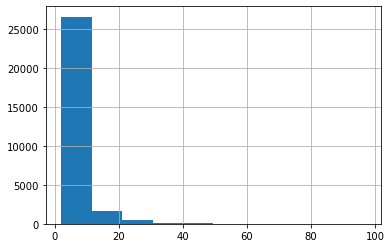

In [99]:
multi_nft.num.hist(bins=10)

In [100]:
explode = multi_nft['NFTS'].explode()

In [101]:
all_nfts = list(set(explode))
#nft_series = pd.Series(all_nfts)

In [102]:
len_nft= len(all_nfts)

In [103]:
matrix = np.zeros((len_nft,len_nft))

In [104]:
def matrix_count(series):
  
    all_nfts #holds all nfts
    combos = list(combinations(series,2))
    
    

    for pair in combos:
        index_0 = all_nfts.index(pair[0])
        index_1 = all_nfts.index(pair[1])
        matrix[index_0,index_1] += 1
        #matrix[index_1,index_0] += 1
        
        #print(index_1, index_0)

        
        
    return None 




In [105]:
multi_nft.NFTS.apply(matrix_count)

4        None
8        None
11       None
14       None
16       None
         ... 
93318    None
93320    None
93325    None
93329    None
93338    None
Name: NFTS, Length: 28907, dtype: object

##### testing the MATRIX

In [108]:
# len(all_nfts)
# all_nfts.index('Enjin'),all_nfts.index("MCP Welcome Pack")
# matrix[904,6617]
all_nfts[2],all_nfts[555]
# multi_nft[multi_nft['NFTS'].apply(lambda x: 'MCP Welcome Pack' in x and 'Enjin' in x)]

('Dapp University', 'Plodding Pirates')

##### Enter the NETWORK

In [85]:
import networkx as nx


In [110]:
G = nx.from_numpy_matrix(matrix)

In [ ]:
# from netwulf import visualize
# visualize(G)

In [ ]:
# [(a,b) for a,b in G.edges(data=True) if "weight" >= 500]
# [(a,b) for a, b, attrs in G.edges(data=True) if attrs["weight"] >1]
# filter(lambda x: g.degree()[x[0]] > 0 and g.degree()[x[1]] > 0, g.edges())
#edgelist = nx.to_edgelist(G)

In [111]:
G.number_of_nodes(), G.number_of_edges()

(10098, 417207)

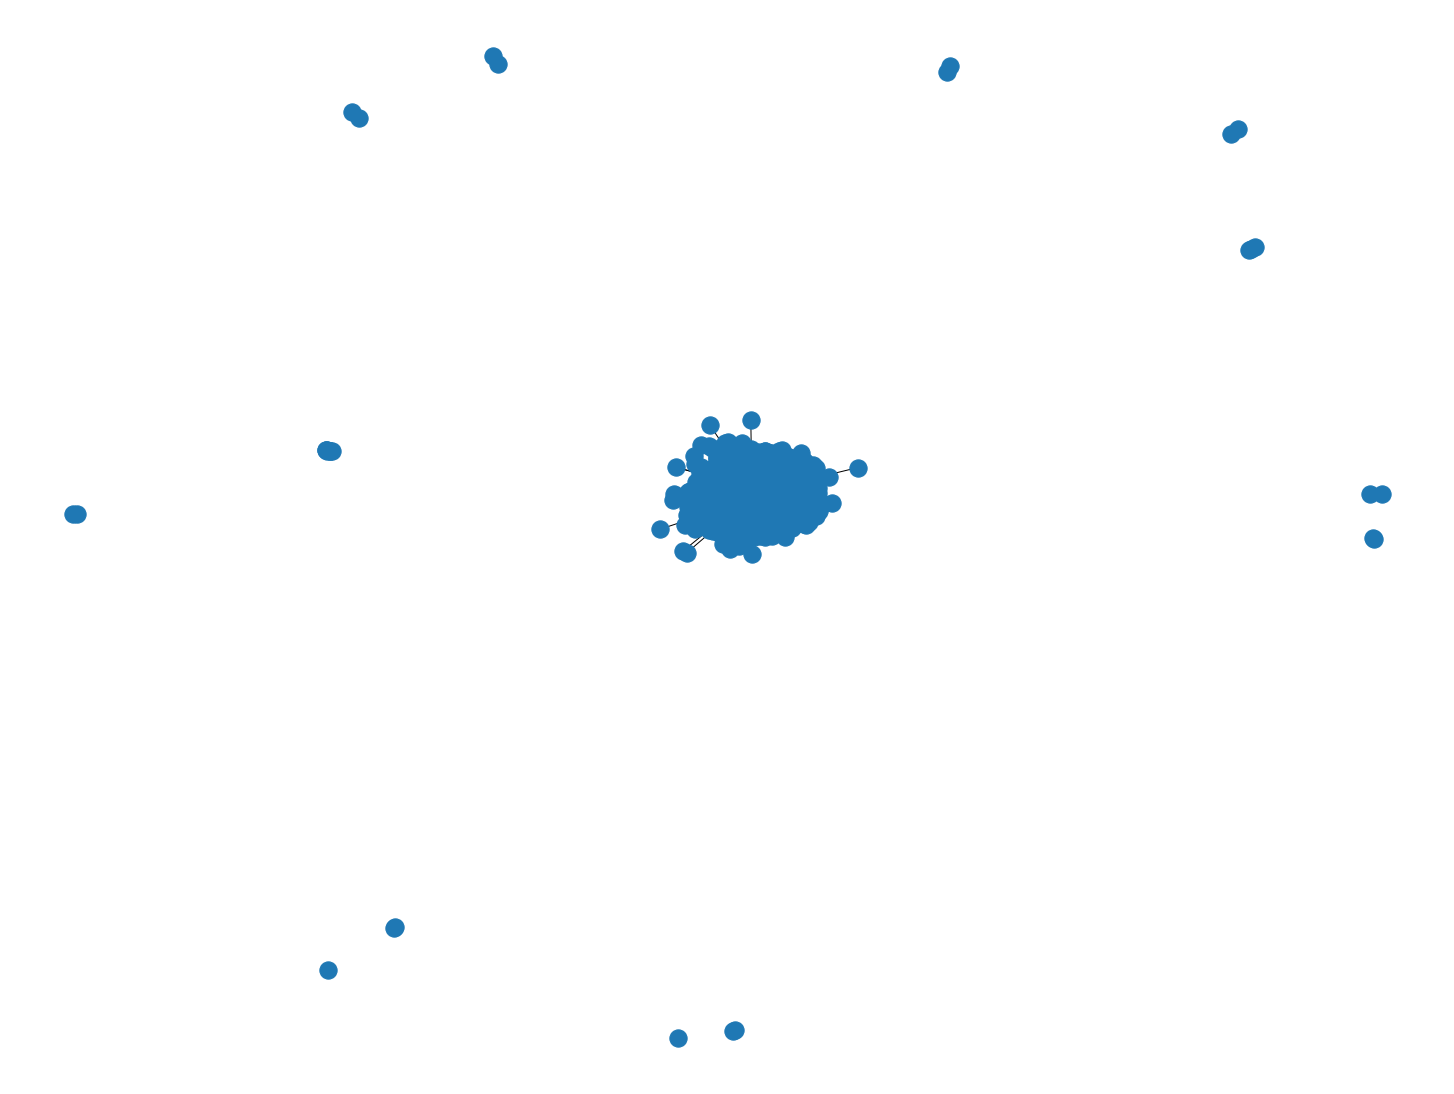

In [112]:
plt.figure(figsize=(20,15))
nx.draw(G)

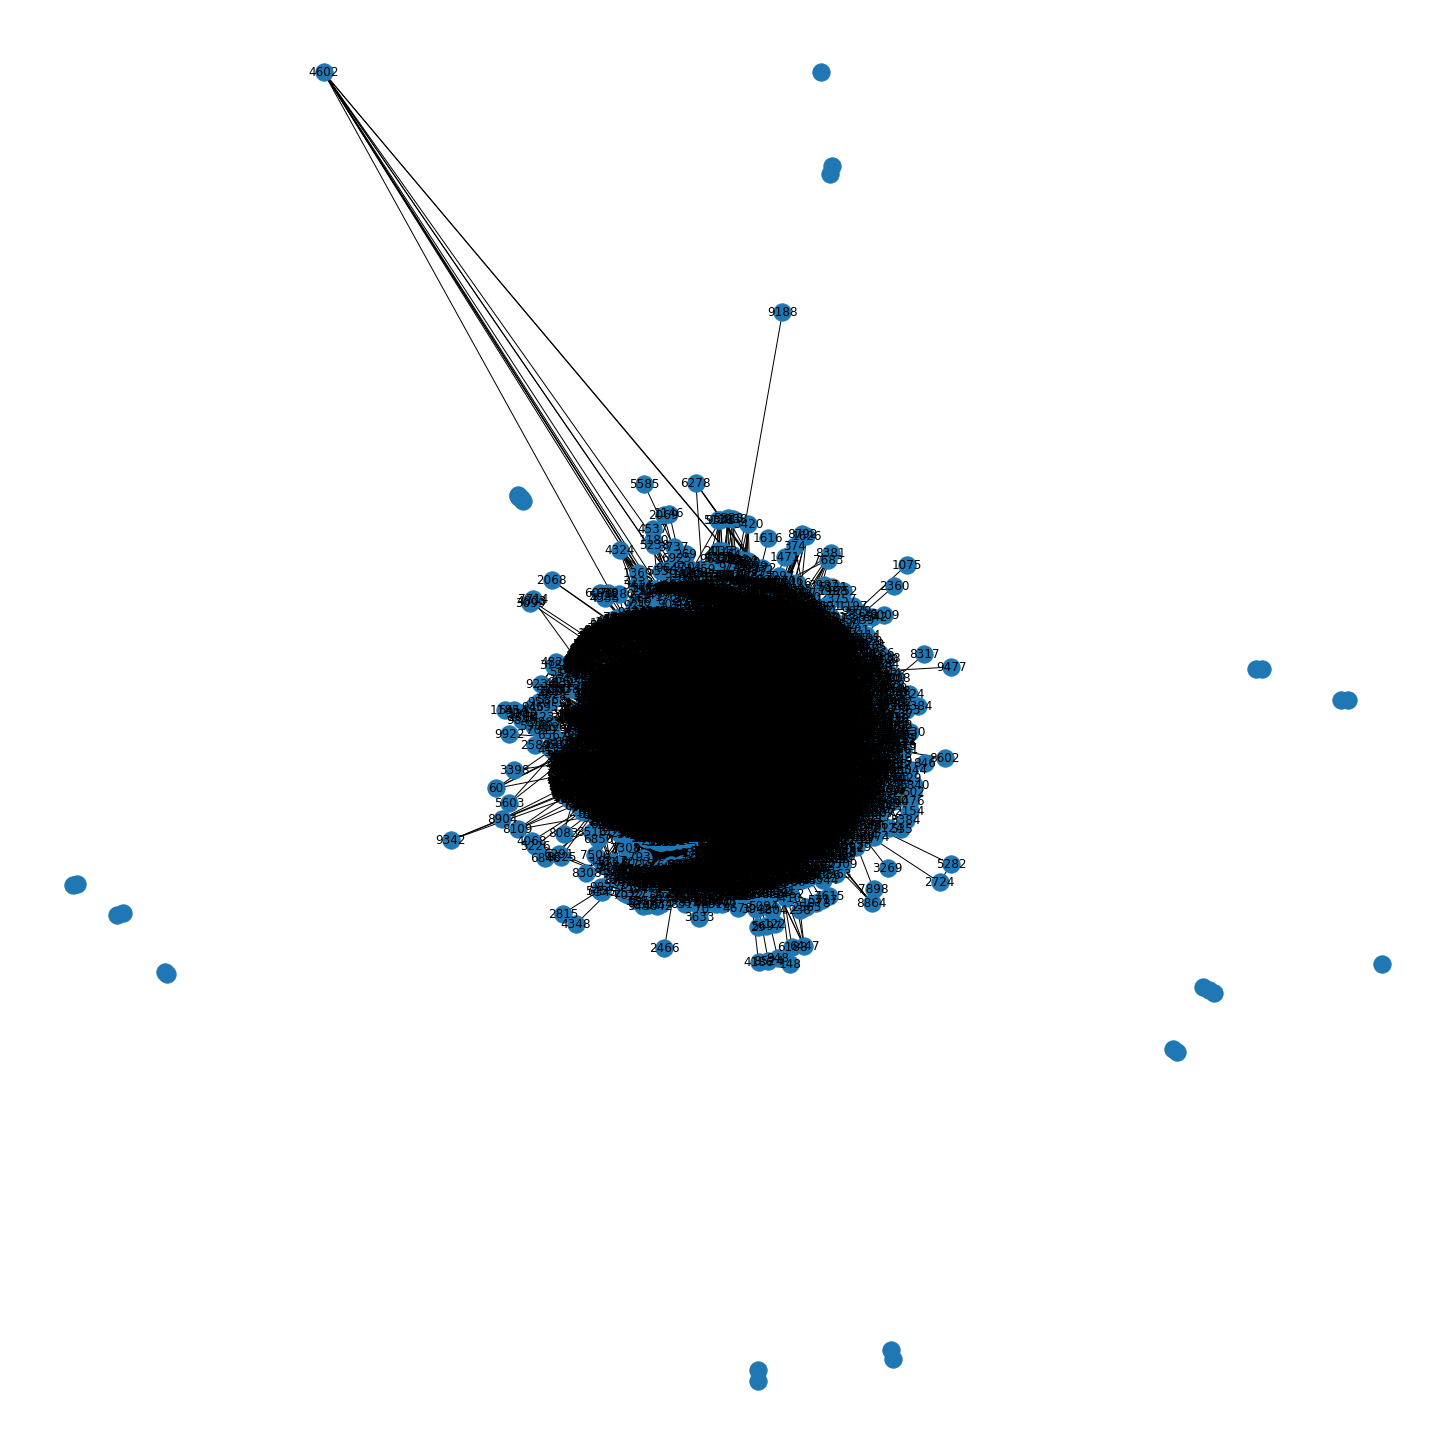

In [96]:
plt.figure(figsize=(20,20))
nx.draw_kamada_kawai(G, with_labels = True)

nx.draw(G)
#plt.savefig("network_Test.pdf",dpi=1000)

In [113]:
nx.transitivity(G) #nx.average_clustering(G)

0.13519351493011386

In [114]:
nx.average_clustering(G)

0.6782728293630464

In [115]:
pr = nx.pagerank(G, alpha=0.5)
#pr = {k:v for k, v in sorted(pr.items(), key=lambda t: t[1], reverse=True)}

In [116]:
prdf = pd.DataFrame.from_dict(pr,orient='index')

In [117]:
prdf.sort_values(by=0, ascending=False).head(50)

,0
8609,0.013299
1016,0.012716
6617,0.008607
3651,0.007006
6090,0.006988
904,0.005925
2914,0.003949
5716,0.003678
5530,0.003551
7335,0.003248


In [118]:
prdf  = prdf.reset_index()

In [119]:
df_all = pd.DataFrame(all_nfts)

In [120]:
df_all =df_all.reset_index()

In [131]:
prdf

,index,0
0,0,0.000123
1,1,0.000050
2,2,0.000054
3,3,0.000054
4,4,0.000050
...,...,...
10093,10093,0.000065
10094,10094,0.000053
10095,10095,0.000121
10096,10096,0.000079


In [132]:
merge = prdf.merge(df_all, on='index')

In [135]:
merge.sort_values(by= '0_x', ascending = False)

,index,0_x,0_y
8609,8609,0.013299,ENS
1016,1016,0.012716,CryptoKitties
6617,6617,0.008607,MCP Welcome Pack
3651,3651,0.007006,Axie
6090,6090,0.006988,Unidentified contract
...,...,...,...
284,284,0.000050,Crypto Slicer
2080,2080,0.000050,GlassEye Animation
7374,7374,0.000050,EQR TOKEN
9590,9590,0.000050,P4L


In [122]:
highest_pr = list(pr.keys())[0:10]
count = 1
for nodes in highest_pr:
    print("{}. {}".format(count, nodes))
    count += 1

1. 0
2. 1
3. 2
4. 3
5. 4
6. 5
7. 6
8. 7
9. 8
10. 9


In [ ]:
all_nfts[661],all_nfts[5763],all_nfts[601]

In [ ]:
cp = iter(G[1073])
dp = iter(G[523])
            

In [ ]:
cp = G[1073]

In [ ]:
G.adj[1073]

In [ ]:
k = G.subgraph([523,1073])

In [ ]:
#nx.draw(k,with_labels = True)

In [ ]:
multi_test[multi_test['NFTS'].apply(lambda x: 'CryptoPunks' in x)]

In [ ]:
all_nfts_test[1073],all_nfts_test[523]

### Getting Summary Stats EDA 

In [ ]:
#HOW MANY EDGES EACH NODE HAS
plt.hist([v for k,v in nx.degree(G)]);

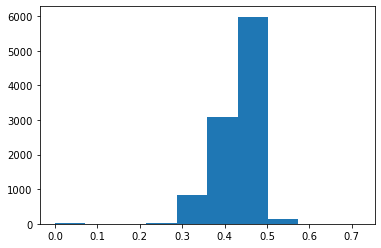

In [123]:
plt.hist(nx.centrality.closeness_centrality(G).values());

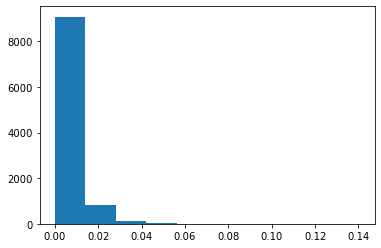

In [124]:
plt.hist(nx.centrality.eigenvector_centrality(G).values());

In [125]:
#plt.hist(nx.centrality.betweenness_centrality(G).values());

In [126]:
# plt.hist(nx.centrality.
         
         
#          (G).values());

In [127]:
#plt.hist(nx.pagerank(G).values());

In [ ]:
nx.cluster.transitivity(G),nx.cluster.average_clustering(G),

In [ ]:
# top50 = list(pr.keys())[0:50]
# count = 1
# for nodes in highest_pr:
#     print("{}. {}".format(count, nodes))
#     count += 1

In [ ]:
plt.figure(figsize=(12,8)) 
top10 = G.subgraph(highest_pr)
nx.draw_networkx(top10)

In [ ]:
plt.figure(figsize=(15,10)) 
top10 = G.subgraph(top10)
nx.draw_networkx(top10)

In [ ]:
pos = hierarchy_pos(G, 0, width = 2*math.pi)
new_pos = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}

In [ ]:
round(nx.average_shortest_path_length(G),4)

In [ ]:
fig = plt.figure(0, figsize=(24, 15))
nx.planar_layout(top50, node_size = 450, with_labels=True, font_size = 10,node_color='blue')
#nx.draw_networkx(top50, node_color = 'Gold', node_size = 1200)

In [ ]:
f =nx.shell_layout(top50)

In [ ]:
pd.Series(nx.betweenness_centrality(G)).sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(12,20)) 
fig.set_facecolor("green")
#edge_colors = ['blue', 'red', 'green', 'orange', 'blue']
pos = nx.multipartite_layout(top50)
nx.draw(top50,with_labels=True,node_shape="o", alpha=0.8, linewidths=25,node_size=300,font_color="black",edgecolors ='gold',width=.85
)


In [ ]:
fig = plt.figure(0, figsize=(24, 15))
pos = hierarchy_pos(G, 0, width = 2*math.pi)
new_pos = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}
nx.draw(G, pos=new_pos, node_size = 450,with_labels=True, font_size = 12,node_color='silver')

node_of_interest = 123

nx.draw_networkx_nodes(G, pos=new_pos, nodelist = [node_of_interest], node_color = 'red', node_size = 640)
nx.draw_networkx_nodes(G, pos=new_pos, nodelist =[147], node_color = 'Gold', node_size = 1200)

In [ ]:
nft_series_test = pd.Series(all_nfts_test)
nft_series_test

In [ ]:
# from pyvis.network import Network
# net = Network(notebook= True)
# net.from_nx(G)
# nt.show_buttons(filter_=['physics'])
# nt.show('test.html')

In [ ]:
#TO DO LIST 


# check if the weight Number on the graph is working the way I think it should. 
# Perhaps cut those that have less than two wallets in common

#firstly Get and define some common network components.(CHECK) 
    #- Histo Gram of Degree.
    # - Histogram of between Centrality 
    # - Historgram of Closeness Centrality. 
    # Avg Clusteing
    # Diameter 
    
    
# Design the graph in a way that is readable.
    #Color by Hghest Centrality. 
    
    #grab network stats in general. 
        # ASP - Avg sohrtest Path
    

        
        # Bored APE - neighborhood visualize 
        # Crypto Punk Neighborhood. 
# Create a predictive alogrithm. 

    # Using Centrality to predict? 
    # predict the price. Or price variance. 
    
    

#Create the pipeline to work on all of the nfts not just a sample. 



In [ ]:
#nx.draw_random(G)

In [128]:
## NETWORK X CALLS 


# draw(G[, pos, ax])
# Draw the graph G with Matplotlib.
# draw_networkx(G[, pos, arrows, with_labels])
# Draw the graph G using Matplotlib.
# draw_networkx_nodes(G, pos[, nodelist, ...])
# Draw the nodes of the graph G.
# draw_networkx_edges(G, pos[, edgelist, ...])
# Draw the edges of the graph G.
# draw_networkx_labels(G, pos[, labels, ...])
# Draw node labels on the graph G.
# draw_networkx_edge_labels(G, pos[, ...])
# Draw edge labels.
# draw_circular(G, **kwargs)
# Draw the graph G with a circular layout.
# draw_kamada_kawai(G, **kwargs)
# Draw the graph G with a Kamada-Kawai force-directed layout.
# draw_planar

## Beginning the Predictions

### Firstly Combine data for Network results Centrality etc. 
### Later merge with data from Google Trends and Twitter

In [138]:
pr_df

,level_0,index,0
0,0,0,0.000123
1,1,1,0.000050
2,2,2,0.000054
3,3,3,0.000054
4,4,4,0.000050
...,...,...,...
10093,10093,10093,0.000065
10094,10094,10094,0.000053
10095,10095,10095,0.000121
10096,10096,10096,0.000079


In [142]:
#pr_df= prdf.reset_index()
#pr_df = pr_df.sort_values('index').reset_index()
pr_df= pr_df.drop('level_0', axis=1)
pr_df = pr_df.rename(columns={0: "pagerank", "index": "id"})

pr_df

,id,pagerank
0,0,0.000123
1,1,0.000050
2,2,0.000054
3,3,0.000054
4,4,0.000050
...,...,...
10093,10093,0.000065
10094,10094,0.000053
10095,10095,0.000121
10096,10096,0.000079


In [144]:
dct = nx.clustering(G)
clus_df = pd.DataFrame.from_dict(dct,orient='index') 
clus_df = clus_df.reset_index()
clus_df = clus_df.rename(columns={0: 'clustering', "index": "id"})
prclus = pd.merge(pr_df,clus_df, on='id')

In [145]:
dct1 = nx.degree_centrality(G)
deg = pd.DataFrame.from_dict(dct1,orient='index') 
deg = deg.reset_index()
deg = deg.rename(columns={0: 'degree_centrality', "index": "id"})
dff3 = pd.merge(deg,prclus, on='id')

In [146]:
dff3.loc[8609]

id                   8609.000000
degree_centrality       0.612063
pagerank                0.013299
clustering              0.017917
Name: 8609, dtype: float64

In [ ]:
import requests

url = "https://api.opensea.io/api/v1/collection/doodles-official/stats"

headers = {"Accept": "application/json"}

response = requests.request("GET", url, headers=headers)

#print(response.text)


j = json.loads(response.text)

NFT['stats']['average_price']

In [147]:
dff3

,id,degree_centrality,pagerank,clustering
0,0,0.011191,0.000123,0.437019
1,1,0.000495,0.000050,1.000000
2,2,0.000891,0.000054,1.000000
3,3,0.001684,0.000054,1.000000
4,4,0.000495,0.000050,1.000000
...,...,...,...,...
10093,10093,0.002872,0.000065,1.000000
10094,10094,0.001585,0.000053,1.000000
10095,10095,0.011191,0.000121,0.368521
10096,10096,0.006239,0.000079,1.000000


In [158]:
dff3 = dff3.rename(columns={0: 'NFT'})

In [150]:
#dff3.drop('key_0',axis=1,inplace=True)

In [ ]:
dff3.drop('index',axis=1,inplace=True)

In [151]:
dff3 = dff3.merge(df_all, on=dff3.index)

In [152]:
nft_price=pd.read_csv('model_data.csv')

In [153]:
nft_price = nft_price.groupby('collection_name').max()

In [159]:
dff3

,key_0,id,degree_centrality,pagerank,clustering,index,NFT
0,0,0,0.011191,0.000123,0.437019,0,Jay Delay
1,1,1,0.000495,0.000050,1.000000,1,bonsai
2,2,2,0.000891,0.000054,1.000000,2,Dapp University
3,3,3,0.001684,0.000054,1.000000,3,RaiseDog
4,4,4,0.000495,0.000050,1.000000,4,SmolMonsters
...,...,...,...,...,...,...,...
10093,10093,10093,0.002872,0.000065,1.000000,10093,Calaveras
10094,10094,10094,0.001585,0.000053,1.000000,10094,Stakefish NFT collection
10095,10095,10095,0.011191,0.000121,0.368521,10095,HolyCows
10096,10096,10096,0.006239,0.000079,1.000000,10096,Nights with Nara


In [155]:
nft_price['NFT']=nft_price.index

In [156]:
nft_price

,created_at,final_vader_score,prices_scaled,previous_day_sentiment,trends,trends_previous_day,trends_two_days_prior,NFT
collection_name,,,,,,,,
0N1 Force,2022-02-24,348.6745,8.040216,348.6745,1.00,1.00,1.00,0N1 Force
3Landers,2022-03-02,1244.8002,2.251890,1244.8002,1.00,1.00,1.00,3Landers
888 Inner Circle,2022-02-09,19.4785,9.265758,19.4785,1.00,1.00,0.21,888 Inner Circle
Adam Bomb Squad,2022-02-24,537.3365,9.946723,537.3365,1.00,1.00,1.00,Adam Bomb Squad
Alienfrens,2022-03-02,54.7554,4.422286,54.7554,1.00,1.00,1.00,Alienfrens
Alpacadabraz,2022-02-23,95.7312,7.686418,95.7312,0.77,0.77,0.77,Alpacadabraz
Animetas,2022-02-05,1522.5760,6.848784,1522.5760,1.00,1.00,1.00,Animetas
Anonymice,2022-02-24,137.7344,7.842699,137.7344,1.00,1.00,1.00,Anonymice
Art Blocks,2021-08-22,60.4996,4.868857,60.4996,0.96,1.00,0.67,Art Blocks


In [160]:
merged =  nft_price.merge(dff3, on='NFT')

In [161]:
merged.prices_scaled.min()

1.5381676999533156

In [162]:
merged

,created_at,final_vader_score,prices_scaled,previous_day_sentiment,trends,trends_previous_day,trends_two_days_prior,NFT,key_0,id,degree_centrality,pagerank,clustering,index
0,2022-02-24,348.6745,8.040216,348.6745,1.00,1.00,1.00,0N1 Force,5981,5981,0.029811,0.000170,0.240310,5981
1,2022-03-02,1244.8002,2.251890,1244.8002,1.00,1.00,1.00,3Landers,1261,1261,0.021492,0.000140,0.256571,1261
2,2022-02-24,537.3365,9.946723,537.3365,1.00,1.00,1.00,Adam Bomb Squad,6263,6263,0.043577,0.000233,0.210955,6263
3,2022-02-05,1522.5760,6.848784,1522.5760,1.00,1.00,1.00,Animetas,3160,3160,0.037338,0.000215,0.216575,3160
4,2022-02-24,137.7344,7.842699,137.7344,1.00,1.00,1.00,Anonymice,1916,1916,0.002179,0.000056,0.670996,1916
5,2021-09-03,33.4551,4.224104,33.4551,0.82,0.82,0.82,Avid Lines,6914,6914,0.001288,0.000058,1.000000,6914
6,2022-02-26,2615.7308,10.993701,2760.0243,0.42,1.00,1.00,Axolittles,160,160,0.045657,0.000239,0.209318,160
7,2022-02-27,1952.7715,11.086487,1952.7715,1.00,1.00,1.00,Bloot,5776,5776,0.049124,0.000245,0.227965,5776
8,2021-12-18,273.1494,10.823827,306.1895,1.00,1.00,1.00,Bored Mummy Waking Up,2672,2672,0.028028,0.000171,0.259579,2672
9,2022-03-02,398.6737,5.381224,398.6737,1.00,0.84,1.00,Boss Beauties,7764,7764,0.016639,0.000115,0.321785,7764


In [163]:
dct2 = nx.betweenness_centrality(G)
btw = pd.DataFrame.from_dict(dct2,orient='index') 
btw = btw.reset_index()
btw = btw.rename(columns={0: 'btw_centrality', "index": "id"})
df4f = pd.merge(btw,dff3, on='id')

In [ ]:
dct3 = nx.load_centrality(G)
load = pd.DataFrame.from_dict(dct3,orient='index') 
load = load.reset_index()
load = load.rename(columns={0: 'load_centrality', "index": "id"})
df5f = pd.merge(load,df4f, on='id')

In [ ]:
dct4 = nx.closeness_centrality(G)
close = pd.DataFrame.from_dict(dct4,orient='index') 
close = close.reset_index()
close = close.rename(columns={0: 'close_centrality', "index": "id"})
df6f = pd.merge(close,df5f, on='id')

In [ ]:
df6f

In [ ]:
train_merge = pd.merge(train2,df6f, how = 'left', on = 'id')
train_merge = train_merge.dropna()

In [ ]:
train_merge

In [ ]:
test_merge = pd.merge(test2,df6f, how = 'left', on = 'id') 

In [ ]:
train_merge

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib.colors import ListedColormap


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.svm import SVC
from sklearn import tree
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_classification


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier

In [ ]:
merged

In [ ]:
X = merged[['degree_centrality','pagerank','clustering']]
y = merged['prices_scaled']

#XX_test = test_merge[['close_centrality','btw_centrality','pagerank','clustering']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1129)

In [ ]:
num = list(X_test.select_dtypes(include=[np.number]))

In [ ]:
full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num),
    ])

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

In [ ]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [ ]:
for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    model = svm.SVC(kernel=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    print(k)
    print(accuracy_score(y_train, y_pred))
    print(mean_absolute_error(y_train, y_pred))

In [ ]:
svc_rbf = svm.SVC(kernel='rbf')
svc_rbf.fit(X_train, y_train)

In [ ]:
rbf_pred = svc_rbf.predict(X_test)
print("MAE Score:", mean_absolute_error(y_test, rbf_pred))

In [ ]:
svc_poly = svm.SVC(kernel='poly')
svc_poly.fit(X_train, y_train)

In [ ]:
poly_pred = svc_poly.predict(X_test)
print("MAE Score:", mean_absolute_error(y_test, poly_pred))

In [ ]:
dtr = DecisionTreeRegressor(random_state=124)

In [ ]:
dtr2 = DecisionTreeRegressor(max_depth=2,random_state=1129,criterion='mae')
dtr3 = DecisionTreeRegressor(max_depth=3,random_state=1129,criterion='mae')
dtr3mse = DecisionTreeRegressor(max_depth=3,random_state=1129,criterion='mse')
dtr5 = DecisionTreeRegressor(max_depth=5,random_state=1129,criterion='mse')
dtr2.fit(X_train, y_train)
dtr3.fit(X_train, y_train)
dtr3mse.fit(X_train, y_train)
dtr5.fit(X_train, y_train)

In [ ]:
dtr2_pred = dtr2.predict(X_test)
dtr3_pred = dtr3.predict(X_test)
dtr3mse_pred = dtr3mse.predict(X_test)
dtr5_pred = dtr5.predict(X_test)

In [ ]:
mean_absolute_error(y_test, dtr2_pred)

In [ ]:
mean_absolute_error(y_test, dtr3_pred)

In [ ]:
mean_absolute_error(y_test, dtr5_pred)

In [ ]:
mean_absolute_error(y_test, dtr3mse_pred)

In [ ]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(dtr3, 
                   feature_names=X.columns,  
                   class_names=y,
                   filled=True)

In [ ]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(dtr3mse, 
                   feature_names=X.columns,  
                   class_names=y,
                   filled=True,
                 )

### TEST MATRIX 

In [ ]:
multi_test = multi_nft.sample(500)

In [ ]:
#remove or keep certain values.

# keepers = ['Enjin','NYC February 19th 2020','PG Wendex Badges',
#            'Hedgies by dYdX, Babylon Prophets',
#      'Zerion Genesis Collection','Rarible','ShadowS',
#      'Alchemist Crucible v1','Codex Record']
#Keeper Logic 
# multi_test.NFTS.apply(lambda x: any(x in keepers for x in x))

# removals = ['Unidentified contract','CryptoKitties','Rarible']

# #Removal Logic 
# def popkitty(series):
#     for NFT in removals: 
#         if NFT in series:
#             series.remove(NFT)

#multi_test.NFTS.apply(popkitty)

# test_df['num'] = test_df['NFTS'].apply(len)
# multi_test = test_df[test_df['num']>1]
# multi_test
#test_explode = multi_test['NFTS'].explode()

#all_nfts_test = list(set(test_explode))
#df_all_test = pd.DataFrame(all_nfts_test)

#len_nft_test= len(all_nfts_test)

#test_matrix = np.zeros((len_nft_test,len_nft_test))

#list(combinations(multi_test['NFTS'].iloc[0],2))

# def matrix_count(series):
#     all_nfts_test #holds all nfts
#     combos = list(combinations(series,2))
#     for pair in combos:
#         index_0 = all_nfts_test.index(pair[0])
#         index_1 = all_nfts_test.index(pair[1])
#         test_matrix[index_0,index_1] += 1
#         #test_matrix[index_1,index_0] += 1
#         print(index_1, index_0)        
#     return None 
##multi_test.NFTS.apply(matrix_count)

##### testing the MATRIX

In [ ]:
# all_nfts_test.index('Enjin'),all_nfts_test.index("MCP Welcome Pack")
# test_matrix[451,764]
# all_nfts_test[813],all_nfts_test[496]
# multi_test[multi_test['NFTS'].apply(lambda x: 'MCP Welcome Pack' in x and 'Enjin' in x)]